In [8]:
import re
import sqlite3
import torch
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from datetime import datetime
from transformers import AutoTokenizer, BertForSequenceClassification, pipeline

torch.cuda.is_available()

True

In [9]:
conn = sqlite3.connect('../letters.db')
cursor = conn.cursor()

res = cursor.execute("""
    select * from letters 
    where gestora = 'IP Capital'
""")

res.fetchone()

(189,
 'IP Capital',
 'Netflix: o terceiro ato da indústria de streaming (RELATÓRIO DE GESTÃO ABRIL 2024)',
 '2024-04-01',
 'https://ip-capitalpartners.com/wp-content/uploads/2024/04/IP_RG_202404_Netflix-1.pdf',
 'Relatório de Gestão | Abril 2024\n1\nRelatório de Gestão\nABRIL 2024\nNetflix: o terceiro ato  \nda indústria de streaming\nRelatório de Gestão | Abril 2024\n2\nNetflix: o terceiro ato da indústria de streaming.\nEm 2024, completaremos 5 anos como acionistas de Netflix. Nossa tese de \ninvestimento foi apresentada pela primeira vez em abril de 2020. De forma resumida, \nacreditávamos que:\n (i) a migração de usuários de TV a cabo para streaming era uma tendência \nsecular inevitável;\n (ii) que a Netflix havia construído uma série de vantagens competitivas que \ngarantiriam a dominância da empresa como o serviço âncora de streaming no \nmundo;\n (iii) isso permitiria que a companhia capturasse uma fatia desproporcional dos \nlucros do setor.\nMontamos a posição a um preço méd

In [10]:
letters = []
cols = [col[0] for col in res.description]

for row in res.fetchall():
    letters.append(dict(zip(cols, row))) 

print(cols)
print(letters[0])

['id', 'gestora', 'title', 'date', 'url', 'content']
{'id': 190, 'gestora': 'IP Capital', 'title': 'Obrigado, Charlie (RELATÓRIO DE GESTÃO DEZEMBRO 2023)', 'date': '2023-12-01', 'url': 'https://ip-capitalpartners.com/wp-content/uploads/2024/01/IP_RG_obrigadocharlie.pdf', 'content': 'Relatório de Gestão | Dezembro 2023\n1\nRelatório de Gestão\nDEZEMBRO 2023\nObrigado, Charlie\nRelatório de Gestão | Dezembro 2023\n2\nRelatório de Gestão\nDEZEMBRO 2023\nIntrodução\nTransDigm\nLocaliza\nAleatórias: Um Tributo a Charlie Munger\n3\n7\n12\n16\nÍndiceRelatório de Gestão | Dezembro 2023\n3\nIntrodução\nEm 2023 vivemos uma descompressão dos mercados após o grande pessimismo \nque marcou 2022. Com os preços voltando a acompanhar a realidade econômica \ne o valor das companhias, os principais índices de ações fecharam 2023 com altos \nretornos: o Ibovespa se valorizou +22%, S&P500 +26%, MSCI World +22%, enquanto \no CDI +13%.\n \n“O que eu acho mais interessante sobre investir é o quão paradoxal i

In [11]:
conn.close()

In [12]:
tokenizer = AutoTokenizer.from_pretrained("lucas-leme/FinBERT-PT-BR")
model = BertForSequenceClassification.from_pretrained("lucas-leme/FinBERT-PT-BR")

finbert = pipeline(task='text-classification', model=model, tokenizer=tokenizer, top_k=None)

Device set to use cuda:0


In [13]:
text = letters[0]['content']
text = text.replace('\n', ' ').replace('  ', ' ')

In [14]:
def generate_chunks(text: str, min_size: int=5, max_size: int=250, punctuation: bool=False) -> list[str]:
    if not text:
        return []
    
    chunks = []
    
    if punctuation:
        sentences = re.split(r'(?<=[.!?])\s+', text)
        
        for sentence in sentences:
            if len(sentence) >= min_size:
                if len(sentence) > 512:
                    current_chunk = []
                    chunk_size = 500

                    words = sentence.split()
                    overlap_words = 5
                    
                    for word in words:
                        current_chunk.append(word)
                        current_text = ' '.join(current_chunk)
                        
                        if len(current_text) >= chunk_size and len(current_chunk) > overlap_words:
                            chunks.append(current_text)
                            current_chunk = current_chunk[-overlap_words:]
                    
                    if current_chunk:
                        final_text = ' '.join(current_chunk)
                        if len(final_text) >= min_size:
                            chunks.append(final_text)
                else:
                    chunks.append(sentence.strip())
    else:
        start = 0
        
        while start < len(text):
            end = min(start + max_size, len(text))
            
            if end < len(text) and text[end] != ' ':
                space_index = text.rfind(' ', start, end)
                if space_index != -1:
                    end = space_index
            
            chunks.append(text[start:end].strip())
            start = end + 1
    
    return chunks

In [15]:
chunks = re.split(r'(?<=[.!?])', text)

for i, chunk in enumerate(chunks, 1):
    print(f"Chunk {i}: {chunk}")


Chunk 1: Relatório de Gestão | Dezembro 2023 1 Relatório de Gestão DEZEMBRO 2023 Obrigado, Charlie Relatório de Gestão | Dezembro 2023 2 Relatório de Gestão DEZEMBRO 2023 Introdução TransDigm Localiza Aleatórias: Um Tributo a Charlie Munger 3 7 12 16 ÍndiceRelatório de Gestão | Dezembro 2023 3 Introdução Em 2023 vivemos uma descompressão dos mercados após o grande pessimismo que marcou 2022.
Chunk 2:  Com os preços voltando a acompanhar a realidade econômica e o valor das companhias, os principais índices de ações fecharam 2023 com altos retornos: o Ibovespa se valorizou +22%, S&P500 +26%, MSCI World +22%, enquanto o CDI +13%.
Chunk 3:   “O que eu acho mais interessante sobre investir é o quão paradoxal isso é: como frequentemente as coisas que parecem mais óbvias, sobre as quais todos concordam, acabam não sendo verdade.
Chunk 4: ” — Howard Marks  O ano de 2023 ficará marcado como uma das claras demonstrações de como os consensos dos mercados frequentemente se provam equivocados.
Chun

In [16]:
def neutral_sentiment_score(scores: list[list[dict]]) -> int:
    score_sums = defaultdict(float)
    count = defaultdict(int)

    for sentence_scores in scores:
        labels = [entry["label"] for entry in sentence_scores]
        scores = np.array([entry["score"] for entry in sentence_scores])

        for i, label in enumerate(labels):
            score_sums[label] += scores[i]
            count[label] += 1

    avg_scores = {label: score_sums[label] / count[label] for label in score_sums}

    final_score = (avg_scores['POSITIVE'] - avg_scores['NEGATIVE'] + 1) / 2 * 100

    return int(final_score)

In [17]:
def sentiment_score(scores: list[list[dict]]) -> int:
    total_pos = 0.0
    total_neg = 0.0

    for chunk in scores:
        p_pos = [x['score'] for x in chunk if x['label'] == 'POSITIVE'][0]
        p_neg = [x['score'] for x in chunk if x['label'] == 'NEGATIVE'][0]

        total_pos += p_pos
        total_neg += p_neg

    sum_pos_neg = total_pos + total_neg

    if sum_pos_neg == 0:
        return 50

    p_pos = total_pos / sum_pos_neg
    p_neg = total_neg / sum_pos_neg

    final_score = (p_pos - p_neg + 1) / 2 * 100

    return int(final_score)

In [18]:
for letter in letters:
    text = letter['content']
    text = text.replace('\n', ' ').replace('  ', ' ')

    chunks = []
    sentences = re.split(r'(?<=[.!?])', text)

    for text in sentences:
        tokens = tokenizer(text, add_special_tokens=False)
        token_length = len(tokens["input_ids"])
    
        if 15 <= token_length <= 500:
            chunks.append(text)

    if not chunks:
        continue

    chunk_count = defaultdict(int)

    results = finbert(chunks)

    for res in results:
        highest_label = max(res, key=lambda x: x['score'])['label']
        chunk_count[highest_label] += 1

    if chunk_count['POSITIVE'] + chunk_count['NEGATIVE'] == 0:
        sentiment_balance = None
    else:
        raw_balance = (chunk_count['POSITIVE'] - chunk_count['NEGATIVE']) / (chunk_count['POSITIVE'] + chunk_count['NEGATIVE'])
        sentiment_balance = (raw_balance + 1) / 2 * 100

    letter['sentiment'] = sentiment_score(results)
    letter['sentiment_neutral'] = neutral_sentiment_score(results)
    letter['sentiment_balance'] = int(sentiment_balance)

    print(f"{letter['title']} - Sentiment: ({letter['sentiment']}) / Sentiment Neutral: ({letter['sentiment_neutral']}) / Sentiment Balance: ({letter['sentiment_balance']})")

Obrigado, Charlie (RELATÓRIO DE GESTÃO DEZEMBRO 2023) - Sentiment: (54) / Sentiment Neutral: (53) / Sentiment Balance: (60)
Cenários, Previsões e o Norte (RELATÓRIO DE GESTÃO JULHO 2023) - Sentiment: (57) / Sentiment Neutral: (55) / Sentiment Balance: (63)
Zoom Out (RELATÓRIO DE GESTÃO JANEIRO 2023) - Sentiment: (57) / Sentiment Neutral: (54) / Sentiment Balance: (64)
Turbulência, disciplina e oportunidades (RELATÓRIO DE GESTÃO JUNHO 2022) - Sentiment: (54) / Sentiment Neutral: (53) / Sentiment Balance: (54)
Web3: Cripto, Blockchain, NFT (DEZ 2021) - Sentiment: (57) / Sentiment Neutral: (54) / Sentiment Balance: (62)
Nossos erros: Não há progresso sem reflexão (MAIO - AGOSTO 2021) - Sentiment: (50) / Sentiment Neutral: (50) / Sentiment Balance: (50)
Pesque onde os peixes estão: a filosofia da qualidade (JANEIRO - ABRIL 2021) - Sentiment: (56) / Sentiment Neutral: (54) / Sentiment Balance: (67)
Os Mais Eficientes Vencerão (SETEMBRO - DEZEMBRO 2020) - Sentiment: (64) / Sentiment Neutral:

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Netflix. Quem não está assistindo? (JANEIRO - ABRIL 2020) - Sentiment: (55) / Sentiment Neutral: (53) / Sentiment Balance: (55)
Relatório de Gestão Charles Schwab, a empresa que inspirou a XP Inc. (DEZEMBRO 2019) - Sentiment: (55) / Sentiment Neutral: (53) / Sentiment Balance: (61)
Relatório de Gestão 3º Trimestre 2019 (MAIO - AGOSTO 2019) - Sentiment: (47) / Sentiment Neutral: (48) / Sentiment Balance: (45)
Relatório de Gestão 1º Trimestre 2019 (JANEIRO - ABRIL 2019) - Sentiment: (53) / Sentiment Neutral: (52) / Sentiment Balance: (57)
Relatório de Gestão 4º Trimestre 2018 (SETEMBRO - DEZEMBRO 2018) - Sentiment: (54) / Sentiment Neutral: (53) / Sentiment Balance: (56)
Relatório de Gestão 30 Anos IP Capital Partners (MAIO - AGOSTO 2018) - Sentiment: (56) / Sentiment Neutral: (53) / Sentiment Balance: (68)
Relatório de Gestão 1º Trimestre 2018 (JANEIRO - ABRIL 2018) - Sentiment: (56) / Sentiment Neutral: (54) / Sentiment Balance: (60)
Relatório de Gestão 4º Trimestre 2017 (OUTUBRO - DEZ

In [21]:
for letter in letters:
    text = letter['content']
    text = text.replace('\n', ' ').replace('  ', ' ')

    chunks = []
    sentences = re.split(r'(?<=[.!?])', text)

    for text in sentences:
        tokens = tokenizer(text, add_special_tokens=False)
        token_length = len(tokens["input_ids"])
    
        if 15 <= token_length <= 500:
            chunks.append(text)

    if not chunks:
        continue

    results = finbert(chunks)

    scores = []
    weights = []

    for chunk in results:

        label_scores = {d['label']: d['score'] for d in chunk}

        p_pos = label_scores['POSITIVE']
        p_neg = label_scores['NEGATIVE']
        p_neu = 1 - (p_pos + p_neg)

        # polarity: s_i = p_pos - p_neg
        s_i = p_pos - p_neg
        
        # weight: w_i = p_pos + p_neg
        w_i = p_pos + p_neg
        
        scores.append(s_i)
        weights.append(w_i)

    all_scores = np.array(scores)
    all_weights = np.array(weights)

    if all_weights.sum() == 0:
        final_score = 50
   
    else:
        # weighted average of chunk polarities
        S = np.sum(all_weights * all_scores) / np.sum(all_weights)  # [-1, +1]
        
        # scale to [0, 100]
        final_score = int(50.0 * (S + 1.0))

    letter['sentiment'] = final_score

    print(f"{letter['title']} - Sentiment: ({letter['sentiment']})")

Obrigado, Charlie (RELATÓRIO DE GESTÃO DEZEMBRO 2023) - Sentiment: (54)
Cenários, Previsões e o Norte (RELATÓRIO DE GESTÃO JULHO 2023) - Sentiment: (56)
Zoom Out (RELATÓRIO DE GESTÃO JANEIRO 2023) - Sentiment: (56)
Turbulência, disciplina e oportunidades (RELATÓRIO DE GESTÃO JUNHO 2022) - Sentiment: (53)
Web3: Cripto, Blockchain, NFT (DEZ 2021) - Sentiment: (54)
Nossos erros: Não há progresso sem reflexão (MAIO - AGOSTO 2021) - Sentiment: (49)
Pesque onde os peixes estão: a filosofia da qualidade (JANEIRO - ABRIL 2021) - Sentiment: (55)
Os Mais Eficientes Vencerão (SETEMBRO - DEZEMBRO 2020) - Sentiment: (62)
Relatório de Gestão Facebook (MAIO - AGOSTO 2020) - Sentiment: (50)
Netflix. Quem não está assistindo? (JANEIRO - ABRIL 2020) - Sentiment: (54)
Relatório de Gestão Charles Schwab, a empresa que inspirou a XP Inc. (DEZEMBRO 2019) - Sentiment: (54)
Relatório de Gestão 3º Trimestre 2019 (MAIO - AGOSTO 2019) - Sentiment: (47)
Relatório de Gestão 1º Trimestre 2019 (JANEIRO - ABRIL 2019)

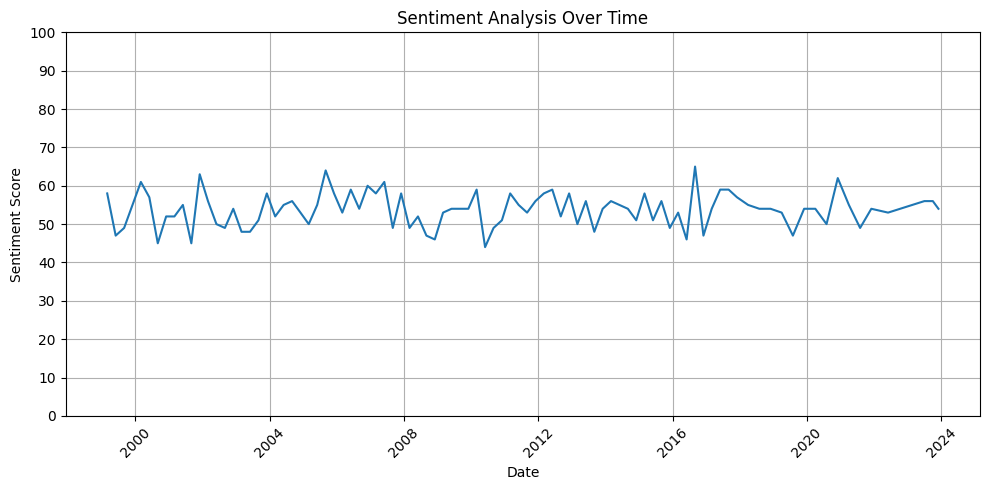

In [ ]:
valid_letters = [letter for letter in letters if letter.get('sentiment') is not None]

sentiment_by_date = {datetime.strptime(letter["date"], "%Y-%m-%d"): letter["sentiment"] for letter in valid_letters}
sorted_sentiment = dict(sorted(sentiment_by_date.items()))

plt.figure(figsize=(10, 5))
plt.plot(sorted_sentiment.keys(), sorted_sentiment.values())
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.title("Sentiment Analysis Over Time")
plt.xticks(rotation=45)
plt.yticks(range(0, 101, 25))
plt.ylim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()